In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor


In [76]:

# Load the dataset
file_path = 'dataset/agriculture_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head(), data.columns


(      Date  Year Experiment   DataUse Replication     Month Vegetation  \
 0   2/9/12  2012   BCSE_KBS  Building          R1  February       Corn   
 1  2/10/12  2012   BCSE_KBS  Building          R1  February       Corn   
 2  2/18/12  2012   BCSE_KBS  Building          R1  February       Corn   
 3  2/19/12  2012   BCSE_KBS  Building          R1  February       Corn   
 4  3/16/12  2012   BCSE_KBS  Building          R1     March       Corn   
 
   VegType       N2O  N_rate  ...   PP7  AirT  DAF_TD  DAF_SD  WFPS25cm  \
 0  Annual  3.896742     170  ...  0.00  -2.0     276     241  0.666508   
 1  Annual  2.190218     170  ...  0.00  -2.4     277     242  0.640608   
 2  Annual  3.542594     170  ...  8.64   0.3     285     250  0.728085   
 3  Annual  3.342870     170  ...  8.13  -3.8     286     251  0.686872   
 4  Annual  2.947778     170  ...  8.39  17.6     312     277  0.716221   
 
          NH4        NO3  Clay   Sand       SOM  
 0  11.046340  22.940812  62.5  637.5  1.17407

In [77]:
# Seleksi fitur numerik dan target kolom N2O
features = data.select_dtypes(include=['float64', 'int64']).columns.drop('N2O')
X = data[features]
y = data['N2O']

# Pra-pemrosesan: Normalisasi dan imputasi nilai yang hilang
scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')

X_scaled = scaler.fit_transform(X)
X_imputed = imputer.fit_transform(X_scaled)

# Isolation Forest untuk mendeteksi outlier
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_scores = iso_forest.fit_predict(X_imputed)
# Initialize Isolation Forest
# iso_forest = IsolationForest(contamination=0.05, random_state=42)
# n2o_data['outliers'] = iso_forest.fit_predict(n2o_data)

# Konversi skor outlier menjadi label biner
outlier_labels = (iso_scores == -1).astype(int)  # 1 untuk outlier, 0 untuk non-outlier

# Naive Bayes untuk mengklasifikasikan data berdasarkan skor outlier
nb_model = GaussianNB()
nb_model.fit(X_imputed, outlier_labels)

# Prediksi label outlier menggunakan Naive Bayes
predicted_outliers = nb_model.predict(X_imputed)

# Convert predictions to -1 for outliers and 1 for inliers
predicted_outliers = [-1 if label == 1 else 1 for label in predicted_outliers]

# 3. Local Outlier Factor
lof_model = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_scores = lof_model.fit_predict(X_imputed)
lof_outliers = lof_scores  # -1 for outliers, 1 for inliers

# Gabungkan data dengan prediksi outlier
# data_with_outlier_predictions = data.assign(by_outlier=predicted_outliers,if_outlier=iso_scores,lof_outlier=lof_scores)
# data_with_outlier_predictions = data.assign(by_outlier=predicted_outliers,if_outlier=iso_scores)
data_with_outlier_predictions = data.assign(lof_outlier=lof_scores)

# Tampilkan beberapa hasil
# print(data_with_outlier_predictions[['N2O','if_outlier' ,'by_outlier','lof_outlier']].head())
# print(data_with_outlier_predictions[['N2O','if_outlier' ,'by_outlier']].head())
print(data_with_outlier_predictions[['N2O','lof_outlier']].head())

        N2O  lof_outlier
0  3.896742            1
1  2.190218            1
2  3.542594            1
3  3.342870            1
4  2.947778            1


In [78]:
data_with_outlier_predictions

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM,lof_outlier
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,-2.00,276,241,0.666508,11.046340,22.940812,62.500000,637.500000,1.174072,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,-2.40,277,242,0.640608,11.008087,22.959578,62.500000,637.500000,1.174072,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,0.30,285,250,0.728085,10.831669,23.221928,62.500000,637.500000,1.174072,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,-3.80,286,251,0.686872,10.849792,23.271978,62.500000,637.500000,1.174072,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,17.60,312,277,0.716221,10.204748,24.206855,62.500000,637.500000,1.174072,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,10.81,167,167,0.390203,17.061793,5.803681,128.333333,491.666667,1.806000,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,5.64,197,197,0.317040,5.624730,5.429873,162.500000,490.375000,1.496400,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,5.64,197,197,0.341428,3.504328,7.239000,183.250000,432.875000,1.186800,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,5.64,197,197,0.365815,3.636931,8.434294,169.833333,418.833333,1.823200,1


In [67]:
models=['if_outlier', 'by_outlier','lof_outlier']
# models=['if_outlier', 'by_outlier']
data_with_outlier_predictions['majority_voting'] = data_with_outlier_predictions.apply(lambda row: 1 if row[models].mode()[0] == 1 else -1, axis=1)

In [68]:
data_with_outlier_predictions

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,WFPS25cm,NH4,NO3,Clay,Sand,SOM,by_outlier,if_outlier,lof_outlier,majority_voting
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,0.666508,11.046340,22.940812,62.500000,637.500000,1.174072,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,0.640608,11.008087,22.959578,62.500000,637.500000,1.174072,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,0.728085,10.831669,23.221928,62.500000,637.500000,1.174072,1,1,1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,0.686872,10.849792,23.271978,62.500000,637.500000,1.174072,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,0.716221,10.204748,24.206855,62.500000,637.500000,1.174072,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,0.390203,17.061793,5.803681,128.333333,491.666667,1.806000,1,1,1,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,0.317040,5.624730,5.429873,162.500000,490.375000,1.496400,1,1,1,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,0.341428,3.504328,7.239000,183.250000,432.875000,1.186800,1,1,1,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,0.365815,3.636931,8.434294,169.833333,418.833333,1.823200,1,1,1,1


In [69]:
data_with_outlier_predictions['average_voting'] = data_with_outlier_predictions[models].mean(axis=1).apply(lambda x: -1 if x < 0 else 1)

In [70]:
weights = {
    'if_outlier': 1,
    'by_outlier': 1,
    'lof_outlier': 1,
}
data_with_outlier_predictions['weighted_voting'] = data_with_outlier_predictions[models].apply(
    lambda row: np.average(row, weights=[weights[name] for name in models]), axis=1).apply(lambda x: -1 if x < 0 else 1)


In [71]:
data_with_outlier_predictions

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,NO3,Clay,Sand,SOM,by_outlier,if_outlier,lof_outlier,majority_voting,average_voting,weighted_voting
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,22.940812,62.500000,637.500000,1.174072,1,1,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,22.959578,62.500000,637.500000,1.174072,1,1,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,23.221928,62.500000,637.500000,1.174072,1,1,1,1,1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,23.271978,62.500000,637.500000,1.174072,1,1,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,24.206855,62.500000,637.500000,1.174072,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,5.803681,128.333333,491.666667,1.806000,1,1,1,1,1,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,5.429873,162.500000,490.375000,1.496400,1,1,1,1,1,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,7.239000,183.250000,432.875000,1.186800,1,1,1,1,1,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,8.434294,169.833333,418.833333,1.823200,1,1,1,1,1,1


In [79]:
# data_with_outlier_predictions.to_csv('dataset/09_05_4_1_AgricultureOutliersVotingBasedResult_IFBYLOF_ONLY.csv', index=False)
data_with_outlier_predictions.to_csv('dataset/09_05_4_1_AgricultureOutliersVotingBasedResult_LOF_ONLY.csv', index=False)
# data_with_outlier_predictions.to_csv('dataset/09_05_4_1_AgricultureOutliersVotingBasedResult_IFBY_ONLY.csv', index=False)


In [81]:
# Generate statistics for each detection method and voting-based result
methods = [
# 'if_outlier', 
# 'by_outlier',
'lof_outlier',
# 'average_voting',
# 'weighted_voting',
# 'majority_voting',
# 'hard_voting'
]

statistics = {}

for method in methods:
    counts = data_with_outlier_predictions[method].value_counts()
    # stats['method']=method
    stats = {
        # 'Method':method,
        'Inliers': counts.get(1, 0),
        'Outliers': counts.get(-1, 0),
        'Total': counts.sum()
    }
    statistics[method] = stats

# Convert the statistics to a data_with_outlier_predictionsFrame for better visualization
statistics_df = pd.DataFrame(statistics).T
# statistics_df.to_csv('dataset/09_05_4_2_AgricultureOutliersVotingBasedStatsSummary_IFBYLOF_ONLY.csv', index=True)
# statistics_df.to_csv('dataset/09_05_4_2_AgricultureOutliersVotingBasedStatsSummary_IFBY_ONLY.csv', index=True)
statistics_df.to_csv('dataset/09_05_4_2_AgricultureOutliersVotingBasedStatsSummary_LOF_ONLY.csv', index=True)
statistics_df

,Inliers,Outliers,Total
lof_outlier,2201,45,2246


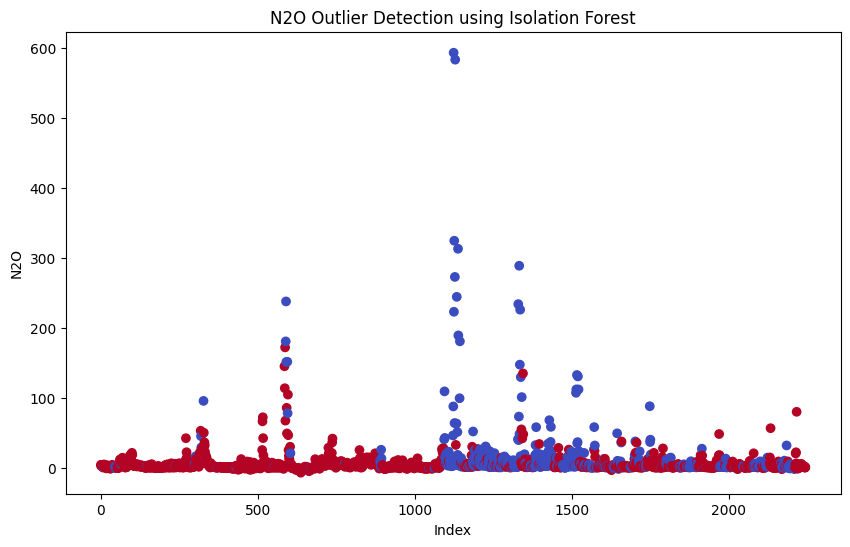

In [74]:
# Isolate the N2O column and drop missing values
# n2o_data = data[['N2O']].dropna()

# # Initialize Isolation Forest
# iso_forest = IsolationForest(contamination=0.05, random_state=42)
# n2o_data['outliers'] = iso_forest.fit_predict(n2o_data)

# Plot the N2O values and highlight outliers
plt.figure(figsize=(10, 6))
plt.scatter(data_with_outlier_predictions.index, data_with_outlier_predictions['N2O'], c=data_with_outlier_predictions['if_outlier'], cmap='coolwarm')
plt.xlabel('Index')
plt.ylabel('N2O')
plt.title('N2O Outlier Detection using Isolation Forest')
plt.show()